In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib


In [9]:
DATA_DIR = "/mnt/data"  
PATIENTS_FP = r"C:\Users\user\Desktop\Patientsatisfctrymodel\patients.csv"
SERVICES_FP = r"C:\Users\user\Desktop\Patientsatisfctrymodel\services_weekly.csv"
STAFF_FP = r"C:\Users\user\Desktop\Patientsatisfctrymodel\staff.csv"
STAFF_SCHEDULE_FP = r"C:\Users\user\Desktop\Patientsatisfctrymodel\staff_schedule.csv"

for fp in [PATIENTS_FP, SERVICES_FP, STAFF_FP,STAFF_SCHEDULE_FP]:
    if not os.path.exists(fp):
        print(f"Warning: {fp} not found. Make sure you uploaded the CSVs to {DATA_DIR}")


In [12]:
patients = pd.read_csv(PATIENTS_FP)
services = pd.read_csv(SERVICES_FP)
staff = pd.read_csv(STAFF_FP)
staff_schedule = pd.read_csv(STAFF_SCHEDULE_FP)

print("patients columns:", patients.columns.tolist())
print("services columns:", services.columns.tolist())
print("staff columns:", staff.columns.tolist())
print("staff_schedule columns:", staff_schedule.columns.tolist())


patients columns: ['patient_id', 'name', 'age', 'arrival_date', 'departure_date', 'service', 'satisfaction']
services columns: ['week', 'month', 'service', 'available_beds', 'patients_request', 'patients_admitted', 'patients_refused', 'patient_satisfaction', 'staff_morale', 'event']
staff columns: ['staff_id', 'staff_name', 'role', 'service']
staff_schedule columns: ['week', 'staff_id', 'staff_name', 'role', 'service', 'present']


In [13]:
display(patients.head())
display(services.head())
display(staff.head())
display(staff_schedule.head())

,patient_id,name,age,arrival_date,departure_date,service,satisfaction
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,1,1,emergency,32,76,32,44,67,70,none
1,1,1,surgery,45,130,45,85,83,78,flu
2,1,1,general_medicine,37,201,37,164,97,43,flu
3,1,1,ICU,22,31,22,9,84,91,flu
4,2,1,emergency,28,169,28,141,75,64,none


,staff_id,staff_name,role,service
0,STF-5ca26577,Allison Hill,doctor,emergency
1,STF-02ae59ca,Noah Rhodes,doctor,emergency
2,STF-d8006e7c,Angie Henderson,doctor,emergency
3,STF-212d8b31,Daniel Wagner,doctor,emergency
4,STF-107a58e4,Cristian Santos,doctor,emergency


,week,staff_id,staff_name,role,service,present
0,1,STF-b77cdc60,Allison Hill,doctor,emergency,1
1,2,STF-b77cdc60,Allison Hill,doctor,emergency,1
2,3,STF-b77cdc60,Allison Hill,doctor,emergency,0
3,4,STF-b77cdc60,Allison Hill,doctor,emergency,1
4,5,STF-b77cdc60,Allison Hill,doctor,emergency,1


In [15]:
date_col_candidates = [c for c in patients.columns if 'date' in c.lower() or 'admit' in c.lower() or 'arrival' in c.lower()]
print("Date-like columns in patients:", date_col_candidates)


Date-like columns in patients: ['arrival_date', 'departure_date']


In [16]:
if 'DateOfAdmission' not in patients.columns:
    if date_col_candidates:
        patients = patients.rename(columns={date_col_candidates[0]:'DateOfAdmission'})
        print("Using", date_col_candidates[0], "as DateOfAdmission")
    else:
        raise KeyError("No DateOfAdmission or date-like column found in pateints.csv: rename the column to include 'date' or 'admit'")

    
    

Using arrival_date as DateOfAdmission


In [17]:
patients['DateOfAdmission'] = pd.to_datetime(patients['DateOfAdmission'], errors='coerce')
n_null_dates = patients['DateOfAdmission'].isna().sum()
print(f"Rows with invalid DateOfAdmission: {n_null_dates}")
patients = patients.dropna(subset=['DateOfAdmission']).reset_index(drop=True)

Rows with invalid DateOfAdmission: 0


In [18]:
patients['DateOfAdmission'] = pd.to_datetime(patients['DateOfAdmission'], errors='coerce')
n_null_dates = patients['DateOfAdmission'].isna().sum()
print(f"Rows with invalid DateOfAdmission: {n_null_dates}")
patients = patients.dropna(subset=['DateOfAdmission']).reset_index(drop=True)

Rows with invalid DateOfAdmission: 0


In [19]:
patients['Week'] = patients['DateOfAdmission'].dt.isocalendar().week.astype(int)
print("Unique weeks in patient data:", patients['Week'].nunique())

Unique weeks in patient data: 52


In [20]:
patients['Year'] = patients['DateOfAdmission'].dt.year
patients['YearWeek'] = patients['DateOfAdmission'].dt.strftime("%Y-W%V") 

In [22]:
svc_week_candidates = [c for c in services.columns if 'week' in c.lower()]
svc_service_candidates = [c for c in services.columns if c.lower() == 'service' or 'service' in c.lower()]

if 'Week' not in services.columns:
    if svc_week_candidates:
        services = services.rename(columns={svc_week_candidates[0]: 'Week'})
    else:
        raise KeyError("services_weekly.csv requires a 'Week' column")

if 'Service' not in services.columns:
    if svc_service_candidates:
        services = services.rename(columns={svc_service_candidates[0]: 'Service'})
    else:
        raise KeyError("services_weekly.csv requires a 'Service' column")
    print("Services columns now:", services.columns.tolist())
display(services.head())

,Week,month,Service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,1,1,emergency,32,76,32,44,67,70,none
1,1,1,surgery,45,130,45,85,83,78,flu
2,1,1,general_medicine,37,201,37,164,97,43,flu
3,1,1,ICU,22,31,22,9,84,91,flu
4,2,1,emergency,28,169,28,141,75,64,none


In [43]:
merge_on = ['Week', 'service'] if 'Week' in services.columns and 'Service' in services.columns else ['YearWeek', 'Service']
print("Merging on:", merge_on)


Merging on: ['Week', 'service']


In [46]:
merged = pd.merge(
    patients,
    services,
    how='left',
    left_on='service',     # column in patients
    right_on='Service'     # column in services
)

In [47]:
print("Merged shape:", merged.shape)
print(merged.head())

Merged shape: (52000, 20)
     patient_id               name  age DateOfAdmission departure_date  \
0  PAT-09484753  Richard Rodriguez   24      2025-03-16     2025-03-22   
1  PAT-09484753  Richard Rodriguez   24      2025-03-16     2025-03-22   
2  PAT-09484753  Richard Rodriguez   24      2025-03-16     2025-03-22   
3  PAT-09484753  Richard Rodriguez   24      2025-03-16     2025-03-22   
4  PAT-09484753  Richard Rodriguez   24      2025-03-16     2025-03-22   

   service  satisfaction  Week_x  Year  YearWeek  Week_y  month  Service  \
0  surgery            61      11  2025  2025-W11       1      1  surgery   
1  surgery            61      11  2025  2025-W11       2      1  surgery   
2  surgery            61      11  2025  2025-W11       3      1  surgery   
3  surgery            61      11  2025  2025-W11       4      1  surgery   
4  surgery            61      11  2025  2025-W11       5      2  surgery   

   available_beds  patients_request  patients_admitted  patients_refused

In [48]:
services.rename(columns={'Service': 'service'}, inplace=True)

In [49]:
merged = pd.merge(patients, services, how='left', on='service')

In [50]:
print(patients.columns)
print(services.columns)

Index(['patient_id', 'name', 'age', 'DateOfAdmission', 'departure_date',
       'service', 'satisfaction', 'Week', 'Year', 'YearWeek'],
      dtype='object')
Index(['Week', 'month', 'service', 'available_beds', 'patients_request',
       'patients_admitted', 'patients_refused', 'patient_satisfaction',
       'staff_morale', 'event'],
      dtype='object')


In [51]:
patients.columns = patients.columns.str.strip()
services.columns = services.columns.str.strip()

In [52]:
merged = pd.merge(patients, services, how='left', on=merge_on, suffixes=('_patient', '_service'))
print("Merged shape:", merged.shape)
display(merged.head())

Merged shape: (1000, 18)


,patient_id,name,age,DateOfAdmission,departure_date,service,satisfaction,Week,Year,YearWeek,month,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61,11,2025,2025-W11,3,48,48,48,0,82,80,none
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83,50,2025,2025-W50,12,59,65,59,6,95,85,none
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83,26,2025,2025-W26,7,43,72,43,29,80,85,none
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81,41,2025,2025-W41,11,27,92,27,65,69,88,none
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76,8,2025,2025-W08,2,12,10,10,0,76,98,none


In [53]:
TARGET = 'SatisfactionScore' 
if TARGET not in merged.columns:
    # Try common alternative
    alt_target = [c for c in merged.columns if 'satisf' in c.lower()]
    if alt_target:
        merged = merged.rename(columns={alt_target[0]: TARGET})
        print("Renamed", alt_target[0], "->", TARGET)
    else:
        raise KeyError(f"Target column {TARGET} not found. Check your patients.csv column names.")

Renamed satisfaction -> SatisfactionScore


In [54]:
candidate_num = ['LengthOfStay', 'BedsAvailable', 'PatientDemand', 'StaffAssigned']


In [57]:
if 'LengthOfStay' not in merged.columns and 'departure_date' in merged.columns:
    merged['departure_date'] = pd.to_datetime(merged['departure_date'], errors='coerce')
    merged['LengthOfStay'] = (merged['departure_date'] - merged['DateOfAdmission']).dt.days
    merged['LengthOfStay'] = merged['LengthOfStay'].fillna(0).clip(lower=0)

In [72]:
num_cols = [c for c in candidate_num if c in merged.columns]
cat_cols = ['service']

print("Numerical features used:", num_cols)
print("Categorical features used:", cat_cols)

feature_cols = num_cols + cat_cols


Numerical features used: ['LengthOfStay']
Categorical features used: ['service']


In [74]:
X = merged[feature_cols].copy()
y = merged[TARGET].copy()
before = X.shape[0]
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]
after = X.shape[0]
print(f"Dropped {before-after} rows with missing features/target. Remaining rows = {after}")

Dropped 0 rows with missing features/target. Remaining rows = 1000


In [76]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


In [77]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

In [78]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [79]:
lr_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [80]:
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

In [82]:
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Linear Regression -- R^2: {:.4f}, MAE: {:.4f}".format(r2_lr, mae_lr))
print("Random Forest       -- R^2: {:.4f}, MAE: {:.4f}".format(r2_rf, mae_rf))

Linear Regression -- R^2: 0.0053, MAE: 10.3671
Random Forest       -- R^2: -0.1135, MAE: 10.8895


In [83]:
if mae_rf < mae_lr:
    best_pipeline = rf_pipeline
    best_name = "RandomForest"
else:
    best_pipeline = lr_pipeline
    best_name = "LinearRegression"
print("Best model by MAE:", best_name)

Best model by MAE: LinearRegression


In [84]:
preproc = best_pipeline.named_steps['preprocessor']
num_features = num_cols

In [85]:
ohe = preproc.named_transformers_['cat'].named_steps['onehot']
try:
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_feature_names = ohe.get_feature_names(cat_cols).tolist()
feature_names = num_features + cat_feature_names
print("Final feature vector length:", len(feature_names))
print("Feature names example:", feature_names[:10])

Final feature vector length: 5
Feature names example: ['LengthOfStay', 'service_ICU', 'service_emergency', 'service_general_medicine', 'service_surgery']


LengthOfStay                0.746532
service_ICU                 0.640865
service_general_medicine   -0.547569
service_emergency          -0.527329
service_surgery             0.434033
dtype: float64


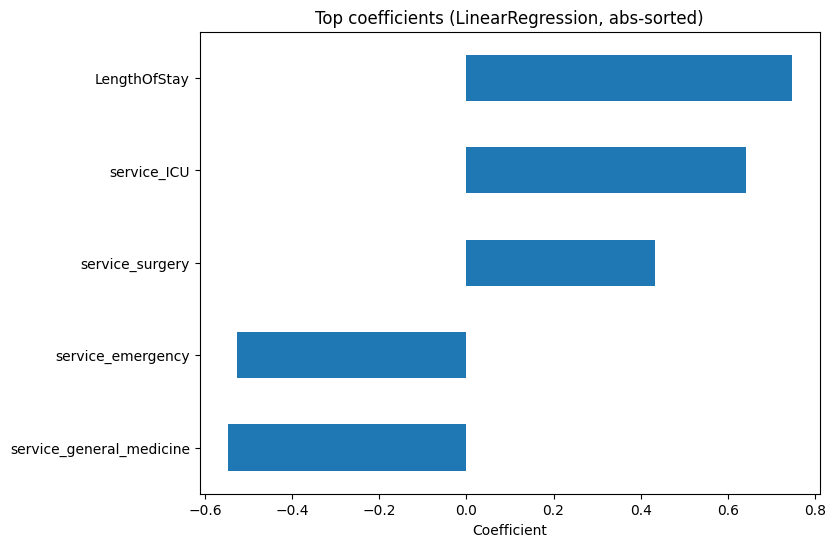

In [86]:
if best_name == "RandomForest":
    model_obj = best_pipeline.named_steps['model']
    importances = model_obj.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print(fi.head(10))
    # Plot
    fi.head(10).sort_values().plot(kind='barh', figsize=(8,6))
    plt.title("Top 10 feature importances (RandomForest)")
    plt.xlabel("Importance")
    plt.show()
else:
    model_obj = best_pipeline.named_steps['model']
    coefs = model_obj.coef_
    coef_s = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
    print(coef_s.head(10))
    coef_s.head(10).sort_values().plot(kind='barh', figsize=(8,6))
    plt.title("Top coefficients (LinearRegression, abs-sorted)")
    plt.xlabel("Coefficient")
    plt.show()

In [87]:
OUTPUT_DIR = DATA_DIR  
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [88]:
joblib.dump(best_pipeline, os.path.join(OUTPUT_DIR, "best_pipeline.joblib"))

['/mnt/data\\best_pipeline.joblib']

In [89]:
joblib.dump(preprocessor, os.path.join(OUTPUT_DIR, "preprocessor.joblib"))

['/mnt/data\\preprocessor.joblib']

In [90]:
joblib.dump(best_pipeline.named_steps['model'], os.path.join(OUTPUT_DIR, "model_only.joblib"))
print("Saved artifacts to", OUTPUT_DIR)

Saved artifacts to /mnt/data
